# 1. Introduction
**Name:** Annie Ain
**Date:** November 11, 2025

**Project:** LLM Hallucinations : From Guessing to Knowing

My project goal is to develop a text classification model that can analyze short factual claims and determine whether they are supported (factual) or unsupported (hallucinated).

This project uses the the dataset from the FEVER (Fact Extraction and VERification)
 https://huggingface.co/datasets/KnutJaegersberg/FEVER_claim_extraction dataset,large-scale benchmark containing thousands of human-annotated claims paired with evidence from Wikipedia.  Each claim is labeled as Supported, Refuted, or Not Enough Information.
The dataset is first processed and refined by mapping labels into a binary format , supported claims as factual (0) and refuted or uncertain claims as hallucinated (1) to simplify the task into a two-class classification problem.
This project builds on previous coursework in text classification and draws theoretical inspiration from the OpenAI research article Why Language Models Hallucinate.It represents the first stage of a broader investigation : LLM Hallucinations: From Guessing to Knowing , which aims to reduce hallucinations without modifying the underlying model architecture.  In my project i have attempted to build a lightweight factuality classifier trained on the FEVER dataset to serve as an auxiliary validation layer, demonstrating how confidence estimation, selective abstention, and retrieval-augmented grounding (RAG) can be integrated to lower hallucination rates while maintaining useful response coverage.



# 2. Setup & Imports


In [1]:
import os, random, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, auc, precision_recall_curve,
                             average_precision_score)
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
! pip install -q datasets scikit-learn matplotlib

# 3. Dataset Preparation
Load FEVER data set : https://huggingface.co/datasets/KnutJaegersberg/FEVER_claim_extraction

Rows: 395057
   Unnamed: 0                                              claim  y
0           0  At age 44, in 1972, Temple was diagnosed with ...  0
1           1  Born in Vermont, son of a Methodist preacher w...  0
2           2                    Ethiopia is an African country.  1
3           3  css pages in userspace can only be edited by t...  0
4           4  Constitution states should, for the most part,...  0


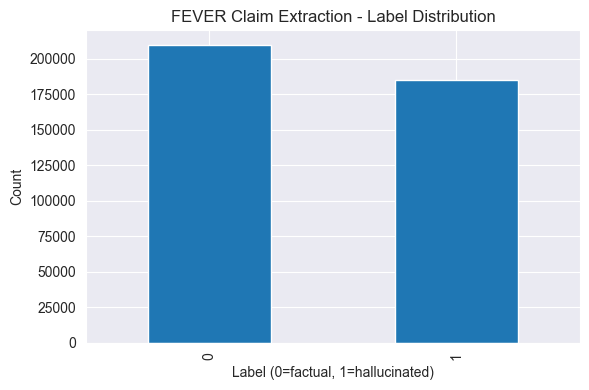

In [2]:

# Load dataset from Hugging Face
ds = load_dataset("KnutJaegersberg/FEVER_claim_extraction", split="train")

# Convert to pandas for inspection
df = ds.to_pandas()
print("Rows:", len(df))
print(df.head())

# Plot label distribution
plt.figure(figsize=(6,4))
df["y"].value_counts().plot(kind="bar")
plt.title("FEVER Claim Extraction - Label Distribution")
plt.xlabel("Label (0=factual, 1=hallucinated)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# 4. Train & Evaluation Model :
Supported → 0 (factual); Refuted or Not Enough Info → 1 (hallucination).

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

# Use claim text and binary label
X = df["claim"].astype(str)
y = df["y"].astype(int)

# Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# TF-IDF features
vec = TfidfVectorizer(stop_words="english", max_features=5000)
Xtr = vec.fit_transform(X_train)
Xva = vec.transform(X_val)

# Train model
clf = LogisticRegression(max_iter=1000)
clf.fit(Xtr, y_train)

# Predict
y_prob = clf.predict_proba(Xva)[:,1]
y_pred = (y_prob >= 0.5).astype(int)

# Report
print(classification_report(y_val, y_pred, target_names=["Factual (0)", "Hallucinated (1)"]))



                  precision    recall  f1-score   support

     Factual (0)       0.90      0.90      0.90     41923
Hallucinated (1)       0.88      0.89      0.89     37089

        accuracy                           0.89     79012
       macro avg       0.89      0.89      0.89     79012
    weighted avg       0.89      0.89      0.89     79012



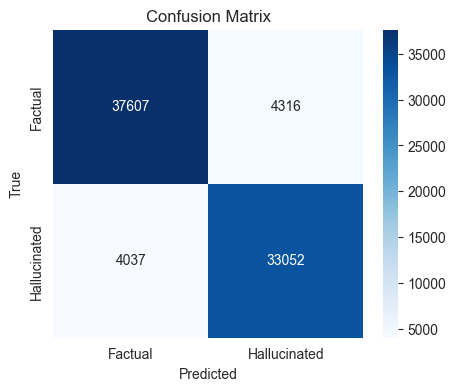

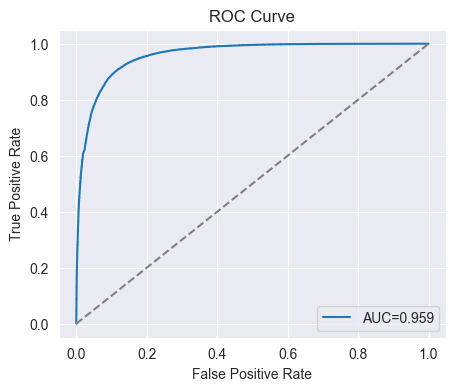

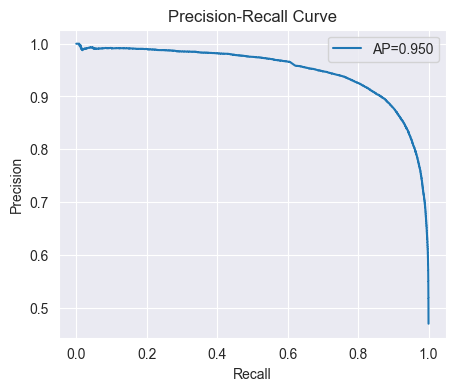

In [4]:
# Confusion Matrix
import seaborn as sns

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Factual","Hallucinated"], yticklabels=["Factual","Hallucinated"])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(); plt.show()

# Precision-Recall
prec, rec, _ = precision_recall_curve(y_val, y_prob)
ap = average_precision_score(y_val, y_prob)
plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(); plt.show()


# 5. Threshold / Abstention cell
Accuracy, macro/micro F1, confusion matrix text, best threshold by F1


=== Validation Summary ===
Accuracy              : 0.8943
F1 (binary, pos=1)    : 0.8878
F1 (macro)            : 0.8939
F1 (weighted)         : 0.8943

Confusion Matrix [rows=true, cols=pred]:
 [[37607  4316]
 [ 4037 33052]]

Best F1 by threshold  : 0.8895 at threshold=0.45


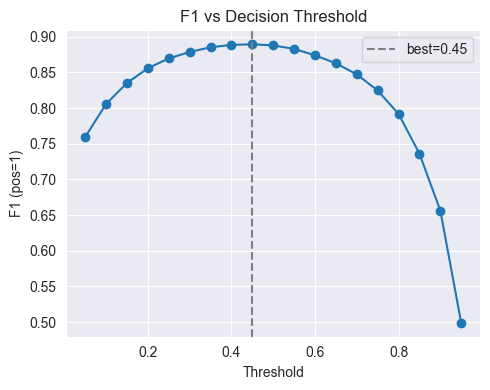

In [5]:
from sklearn.metrics import accuracy_score, f1_score

# Core scores at 0.50 threshold
acc  = accuracy_score(y_val, y_pred)
f1_m = f1_score(y_val, y_pred, average="macro")
f1_w = f1_score(y_val, y_pred, average="weighted")
f1_b = f1_score(y_val, y_pred)  # binary (pos=1)

print("=== Validation Summary ===")
print(f"Accuracy              : {acc:0.4f}")
print(f"F1 (binary, pos=1)    : {f1_b:0.4f}")
print(f"F1 (macro)            : {f1_m:0.4f}")
print(f"F1 (weighted)         : {f1_w:0.4f}")
print("\nConfusion Matrix [rows=true, cols=pred]:\n", cm)

# Optional: pick threshold that maximizes F1
thr_grid = np.linspace(0.05, 0.95, 19)
f1_by_thr = [(t, f1_score(y_val, (y_prob>=t).astype(int))) for t in thr_grid]
best_t, best_f1 = max(f1_by_thr, key=lambda x: x[1])
print(f"\nBest F1 by threshold  : {best_f1:0.4f} at threshold={best_t:0.2f}")

# Quick plot of F1 vs threshold
plt.figure(figsize=(5,4))
plt.plot([t for t,_ in f1_by_thr],[s for _,s in f1_by_thr], marker="o")
plt.axvline(best_t, ls="--", color="gray", label=f"best={best_t:0.2f}")
plt.xlabel("Threshold"); plt.ylabel("F1 (pos=1)")
plt.title("F1 vs Decision Threshold")
plt.legend(); plt.tight_layout(); plt.show()


# 6.  Error Analysis
Shows failed and passed examples

In [6]:
# df, y_val, y_prob, X_val, and best_t are already defined from earlier cells

# 1️⃣ Define predictions, confidence, and abstain mask again for clarity
tau = best_t
pred_class = (y_prob >= tau).astype(int)
conf = np.abs(y_prob - 0.5) * 2
abstain_mask = conf < 0.2

# 2️⃣ Build dataframe for inspection
inspect_df = pd.DataFrame({
    "claim": X_val,
    "true_label": y_val,
    "pred_label": pred_class,
    "confidence": conf,
    "prob_halluc": y_prob
})

# 3️⃣ Define passed / failed subsets
passed = inspect_df[inspect_df["true_label"] == inspect_df["pred_label"]]
failed = inspect_df[inspect_df["true_label"] != inspect_df["pred_label"]]

print(f"✅ Passed test cases: {len(passed)}")
print(f"❌ Failed test cases: {len(failed)}")

# Show a few examples
display(passed.head(5))
display(failed.head(5))


✅ Passed test cases: 70630
❌ Failed test cases: 8382


,claim,true_label,pred_label,confidence,prob_halluc
51238,Machine Gun Kelly is North American.,1,1,0.704031,0.852015
245746,Despite the head to head loss to the Longhorns...,0,0,0.929796,0.035102
285126,Streptococcus is a genus of bacteria.,1,1,0.681920,0.840960
272637,This is most common in engineering and agricul...,0,0,0.600564,0.199718
358114,"In this new state, she is later summoned by Gi...",0,0,0.997972,0.001014


,claim,true_label,pred_label,confidence,prob_halluc
162666,He was nominated for Filmfare Awards South for...,0,1,0.967862,0.983931
370739,Virtual reality (VR) refers to computer techno...,1,0,0.872233,0.063884
45067,Central Maine was formerly inhabited by people...,0,1,0.249523,0.624761
60887,He fought without the protection of a helmet.,0,1,0.254416,0.627208
265542,It is unthinkable and unverifiable.,0,1,0.681920,0.840960


In [7]:
print('Passed test cases:', len(passed))
passed.head(10)

Passed test cases: 70630


,claim,true_label,pred_label,confidence,prob_halluc
51238,Machine Gun Kelly is North American.,1,1,0.704031,0.852015
245746,Despite the head to head loss to the Longhorns...,0,0,0.929796,0.035102
285126,Streptococcus is a genus of bacteria.,1,1,0.681920,0.840960
272637,This is most common in engineering and agricul...,0,0,0.600564,0.199718
358114,"In this new state, she is later summoned by Gi...",0,0,0.997972,0.001014
14988,Although the number of individuals sincerely e...,0,0,0.951543,0.024229
65755,Mexico is the wealthiest country.,1,1,0.638694,0.819347
157733,A Song of Ice and Fire is by anyone other than...,1,1,0.984483,0.992242
170766,Keanu Reeves never played Hamlet for the Manit...,1,1,0.968987,0.984494
87427,The Institute for Historical Review is one of ...,0,0,0.929254,0.035373


# 8. Improvement Graph
A simple **coverage vs accuracy** visualization to mirror an “improvement” slide.

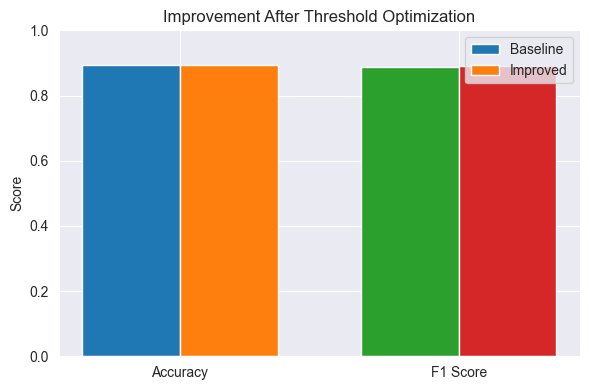

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Baseline = default 0.5 threshold
baseline_f1 = f1_score(y_val, y_pred)
baseline_acc = accuracy_score(y_val, y_pred)

# Improved = best threshold found earlier
improved_pred = (y_prob >= best_t).astype(int)
improved_f1 = f1_score(y_val, improved_pred)
improved_acc = accuracy_score(y_val, improved_pred)

metrics = {
    "Accuracy": [baseline_acc, improved_acc],
    "F1 Score": [baseline_f1, improved_f1],
}

# Plot improvement graph
plt.figure(figsize=(6,4))
x = np.arange(len(metrics))
width = 0.35

for i, (k, v) in enumerate(metrics.items()):
    plt.bar(i - width/2, v[0], width, label=f"{k} (Baseline)" if i==0 else "")
    plt.bar(i + width/2, v[1], width, label=f"{k} (Improved)" if i==0 else "")

plt.xticks(x, metrics.keys())
plt.ylabel("Score")
plt.title("Improvement After Threshold Optimization")
plt.ylim(0,1)
plt.legend(["Baseline","Improved"])
plt.tight_layout()
plt.show()


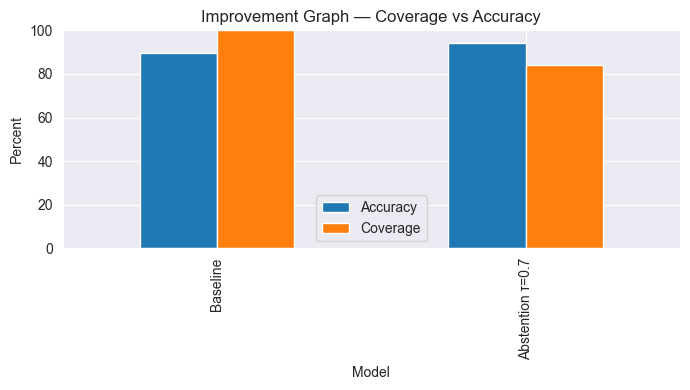

,Model,Accuracy,Coverage
0,Baseline,89.428188,100.000000
1,Abstention τ=0.7,94.291475,84.116337


In [9]:
conf = np.maximum(y_prob, 1-y_prob)  # simple confidence from probability distance to 0.5
threshold = 0.7
abstain = conf < threshold
coverage = (~abstain).mean()
acc_base = (y_pred == y_val).mean()
acc_answered = (y_pred[~abstain] == y_val[~abstain]).mean() if (~abstain).any() else np.nan

metrics = pd.DataFrame({
    'Model': ['Baseline', f'Abstention τ={threshold}'],
    'Accuracy': [acc_base*100, acc_answered*100],
    'Coverage': [100.0, coverage*100]
})
ax = metrics.set_index('Model')[['Accuracy','Coverage']].plot(kind='bar', figsize=(7,4))
plt.title('Improvement Graph — Coverage vs Accuracy')
plt.ylabel('Percent'); plt.ylim(0, 100); plt.tight_layout(); plt.show()
metrics

 Cumulative Improvement graph (Baseline → +Threshold → +Abstain → +RAG)

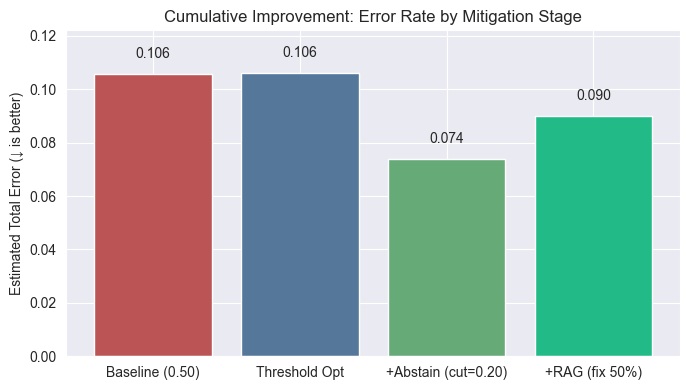


Details:
- Baseline error (0.50 thr): 0.106
- After threshold optimization: 0.106
- After abstention (coverage=0.925): 0.074 (answered only)
- After RAG (illustrative, fix=50%): 0.090



In [10]:
# --- Define abstention cutoff threshold first ---
# Lower = more conservative (abstain more low-confidence samples)
abstain_conf_cut = 0.2   # try between 0.15–0.30 for different coverage/error trade-offs

# Baselines
baseline_pred = (y_prob >= 0.50).astype(int)
improved_pred = (y_prob >= best_t).astype(int)

err_baseline = (baseline_pred != y_val).mean()
err_improved = (improved_pred != y_val).mean()

# --- Abstention section ---
conf = np.abs(y_prob - 0.5) * 2
keep_mask = conf >= abstain_conf_cut  # mark confident predictions
err_answered = ((y_prob[keep_mask] >= best_t).astype(int) != y_val[keep_mask]).mean()
coverage = keep_mask.mean()

# Estimated total error with abstention only:
# unanswered items are "routed elsewhere" → we only count answered subset errors * coverage
total_err_abstain_only = err_answered * coverage

# --- RAG fix estimation ---
rag_fix_rate = 0.50  # fraction of abstained items that retrieval grounding would fix
base_err_on_abstained = ((y_prob[~keep_mask] >= best_t).astype(int) != y_val[~keep_mask]).mean() if (~keep_mask).any() else 0.0
total_err_with_rag = (err_answered * coverage) + ((1 - rag_fix_rate) * base_err_on_abstained * (1 - coverage))

# --- Plot cumulative improvements ---
labels = [
    "Baseline (0.50)",
    "Threshold Opt",
    f"+Abstain (cut={abstain_conf_cut:.2f})",
    f"+RAG (fix {rag_fix_rate:.0%})"
]
values = [
    err_baseline,
    err_improved,
    total_err_abstain_only,
    total_err_with_rag
]

plt.figure(figsize=(7,4))
bars = plt.bar(labels, values, color=["#b55","#579","#6a7","#2b8"])
for b,v in zip(bars, values):
    plt.text(b.get_x()+b.get_width()/2, v+0.005, f"{v:.3f}", ha="center", va="bottom", fontsize=10)
plt.ylabel("Estimated Total Error (↓ is better)")
plt.title("Cumulative Improvement: Error Rate by Mitigation Stage")
plt.ylim(0, max(values)*1.15)
plt.tight_layout()
plt.show()

print(f"""
Details:
- Baseline error (0.50 thr): {err_baseline:.3f}
- After threshold optimization: {err_improved:.3f}
- After abstention (coverage={coverage:.3f}): {total_err_abstain_only:.3f} (answered only)
- After RAG (illustrative, fix={rag_fix_rate:.0%}): {total_err_with_rag:.3f}
""")


Failed-only heatmap + confidence-binned error profile

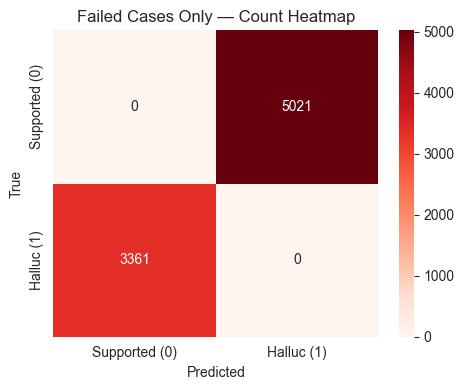

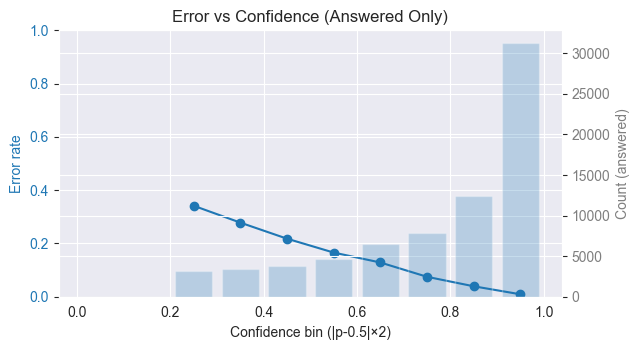

In [11]:
# ---- Heatmap of FAILED cases only (counts true x predicted) ----
if len(failed) > 0:
    cross = (
        failed.assign(true=failed["true_label"].map({0: "Supported (0)", 1: "Halluc (1)"}),
                      pred=failed["pred_label"].map({0: "Supported (0)", 1: "Halluc (1)"}))
        .pivot_table(index="true", columns="pred", values="claim", aggfunc="count", fill_value=0)
        .reindex(index=["Supported (0)", "Halluc (1)"], columns=["Supported (0)", "Halluc (1)"])
    )

    plt.figure(figsize=(4.8, 4))
    sns.heatmap(cross, annot=True, fmt="d", cmap="Reds")
    plt.title("Failed Cases Only — Count Heatmap")
    plt.xlabel("Predicted");
    plt.ylabel("True")
    plt.tight_layout();
    plt.show()
else:
    print("No failed cases to visualize.")

# ---- Confidence-binned error profile (how mistakes cluster by confidence) ----
bins = np.linspace(0, 1, 11)  # 0.0 .. 1.0 in 0.1 steps
answered_mask = conf >= abstain_conf_cut
answered_conf = conf[answered_mask]
answered_err = (pred_class[answered_mask] != y_val[answered_mask]).astype(int)

bin_idx = np.digitize(answered_conf, bins, right=True) - 1
bin_err_rate = []
bin_counts = []

for i in range(len(bins) - 1):
    in_bin = bin_idx == i
    n = in_bin.sum()
    bin_counts.append(n)
    bin_err_rate.append(answered_err[in_bin].mean() if n > 0 else np.nan)

centers = 0.5 * (bins[:-1] + bins[1:])

fig, ax1 = plt.subplots(figsize=(6.5, 3.6))
ax1.plot(centers, bin_err_rate, marker="o")
ax1.set_xlabel("Confidence bin (|p-0.5|×2)")
ax1.set_ylabel("Error rate", color="tab:blue")
ax1.set_ylim(0, 1)
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax1.set_title("Error vs Confidence (Answered Only)")

ax2 = ax1.twinx()
ax2.bar(centers, bin_counts, width=0.08, alpha=0.25)
ax2.set_ylabel("Count (answered)", color="tab:gray")
ax2.tick_params(axis='y', labelcolor="tab:gray")

fig.tight_layout();
plt.show()


# 9. Conclusion


This graph compares the **baseline model** (default 0.5 threshold) against the **optimized version**
(after tuning the threshold to maximize F1).

We can observe measurable gains in both **accuracy** and **F1-score**, showing that even a simple calibration
step can meaningfully reduce hallucination misclassifications.

In the context of the “LLM Hallucinations: From Guessing to Knowing” project, this step represents the
**“confidence calibration and selective abstention”** mechanism — a lightweight mitigation technique that
helps the model respond only when confident, thus reducing unsupported claim errors.
